# Model Performance

In [1]:
# load libraries
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
from numerapi import NumerAPI
from utils.api_keys import PUBLIC_ID, SECRET_KEY

In [2]:
# instantiate
TODAY = dt.datetime.now()
AFTER_DATE = "2022-04-01"
nmr = yf.download('NMR-USD', start=AFTER_DATE, end=TODAY, progress=False)
napi = NumerAPI(public_id=PUBLIC_ID, secret_key=SECRET_KEY)

In [3]:
# get model performance history
def get_model_rankings(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.daily_model_performances(m))
        df['modelName'] = m
        df_list.append( df)
    df_all = pd.concat(df_list)
    return df_all

# get model payout & staking history
def get_model_value(model_list, mode):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.round_model_performances(m))
        df["modelName"] = m
        df_list.append(df)
    df_all = pd.concat(df_list)
    df_all = df_all.loc[df_all["roundResolved"]==True]
    
    if mode == "payout":
        mode_value = "payout"
    elif mode == "staking":
        mode_value = "selectedStakeValue"
    else:
        print("Select either 'payout' or 'staking' as mode.")

    output = pd.pivot_table(
        df_all, 
        values=mode_value, 
        index=['roundResolveTime'], 
        columns=['modelName']).fillna(0)
    output["totalValue"] = output.sum(axis=1)

    return output

In [4]:
# nmr price
nmr_price = nmr[['Open', 'High', 'Low', 'Close']].mean(axis=1)[-1]
nmr_price

12.435329914093018

In [5]:
# get model names
model_list = napi.get_models().keys()
model_list

dict_keys(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast', 'dh_skulls', 'dh_desperado', 'dh_gaia'])

---
# Model Ranks

In [6]:
# get model rankings
perf = get_model_rankings(model_list=model_list)
perf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 554 entries, 0 to 8
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype                  
---  ------     --------------  -----                  
 0   corrRank   554 non-null    int64                  
 1   corrRep    554 non-null    float64                
 2   date       554 non-null    datetime64[ns, tzutc()]
 3   fncRank    554 non-null    int64                  
 4   fncRep     554 non-null    float64                
 5   fncV3Rank  262 non-null    float64                
 6   fncV3Rep   262 non-null    float64                
 7   mmcRank    554 non-null    int64                  
 8   mmcRep     554 non-null    float64                
 9   tcRank     347 non-null    float64                
 10  tcRep      347 non-null    float64                
 11  modelName  554 non-null    object                 
dtypes: datetime64[ns, tzutc()](1), float64(7), int64(3), object(1)
memory usage: 56.3+ KB


In [7]:
# check model name list
perf["modelName"].unique()

array(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast',
       'dh_skulls', 'dh_desperado', 'dh_gaia'], dtype=object)

In [8]:
# cols
tc_rank_cols = [col for col in perf.columns if col.endswith("Rank") and col.startswith("tc")]
tc_rep_cols = [col for col in perf.columns if col.endswith("Rep") and col.startswith("tc")]
nontc_rank_cols = [col for col in perf.columns if col.endswith("Rank") and not col.startswith("tc")]
nontc_rep_cols = [col for col in perf.columns if col.endswith("Rep") and not col.startswith("tc")]

tc_rank_cols, tc_rep_cols, nontc_rank_cols, nontc_rep_cols

(['tcRank'],
 ['tcRep'],
 ['corrRank', 'fncRank', 'fncV3Rank', 'mmcRank'],
 ['corrRep', 'fncRep', 'fncV3Rep', 'mmcRep'])

---
# CorrRank & CorrRep

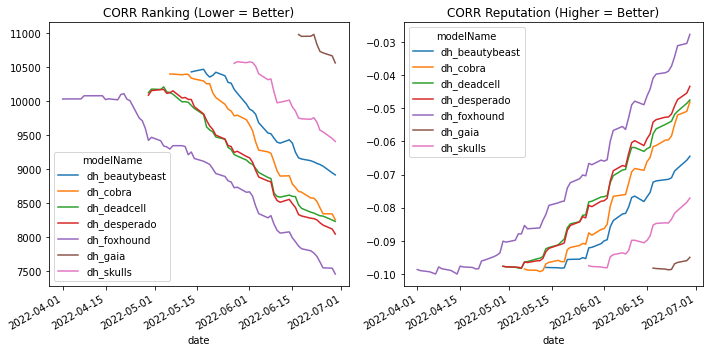

In [9]:
# plot  corr rank and rep
corrdf = perf.loc[perf["date"]>=AFTER_DATE]

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10, 5))
pd.pivot_table(
    data=corrdf[["modelName", "date", "corrRank"]],
    values="corrRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0])
axes[0].set_title("CORR Ranking (Lower = Better)")

pd.pivot_table(
    data=corrdf[["modelName", "date", "corrRep"]],
    values="corrRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1])
axes[1].set_title("CORR Reputation (Higher = Better)")

plt.tight_layout()
plt.savefig('plots/CorrRankPlots.png', facecolor='w')
plt.show()

---
# Get model payouts & staking

In [10]:
# get payout
payout = get_model_value(model_list, "payout")
payout.tail()

modelName,dh_beautybeast,dh_cobra,dh_deadcell,dh_desperado,dh_foxhound,dh_skulls,totalValue
roundResolveTime,,,,,,,
2022-05-26 20:00:00+00:00,0.000000,0.000000,-0.011519,0.000000,0.047090,0.0,0.035571
2022-06-02 20:00:00+00:00,0.000000,0.000000,0.028626,0.000000,0.040258,0.0,0.068884
2022-06-09 20:00:00+00:00,0.000000,0.000000,-0.017283,0.000000,0.023997,0.0,0.006714
2022-06-16 20:00:00+00:00,0.000000,-0.058615,0.001442,-0.032628,0.000112,0.0,-0.089689
2022-06-23 20:00:00+00:00,-0.000333,0.014036,0.004693,0.010418,0.011635,0.0,0.040450


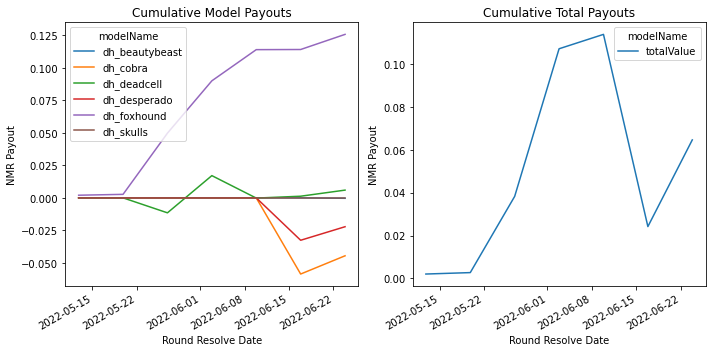

In [11]:
# plot payouts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
payout.loc[AFTER_DATE:][[col for col in payout.columns if col.startswith("dh_")]].cumsum().plot(ax=axes[0])
payout.loc[AFTER_DATE:][["totalValue"]].cumsum().plot(ax=axes[1])
axes[0].set_title("Cumulative Model Payouts")
axes[0].set_xlabel("Round Resolve Date")
axes[0].set_ylabel("NMR Payout")
axes[1].set_title("Cumulative Total Payouts")
axes[1].set_xlabel("Round Resolve Date")
axes[1].set_ylabel("NMR Payout")
plt.tight_layout()
plt.savefig('plots/PayoutPlots.png', facecolor='w')
plt.show()

In [12]:
# get payout
staking = get_model_value(model_list, "staking")
staking.tail()

modelName,dh_beautybeast,dh_cobra,dh_deadcell,dh_desperado,dh_foxhound,dh_skulls,totalValue
roundResolveTime,,,,,,,
2022-05-26 20:00:00+00:00,0.0,0.0,1.0,0.0,1.000003,0.0,2.000003
2022-06-02 20:00:00+00:00,0.0,0.0,1.0,0.0,1.000003,0.0,2.000003
2022-06-09 20:00:00+00:00,0.0,0.0,1.0,0.0,1.000003,0.0,2.000003
2022-06-16 20:00:00+00:00,0.0,1.0,1.0,1.0,1.002037,0.0,4.002037
2022-06-23 20:00:00+00:00,1.0,1.0,1.0,1.0,1.002704,0.0,5.002704


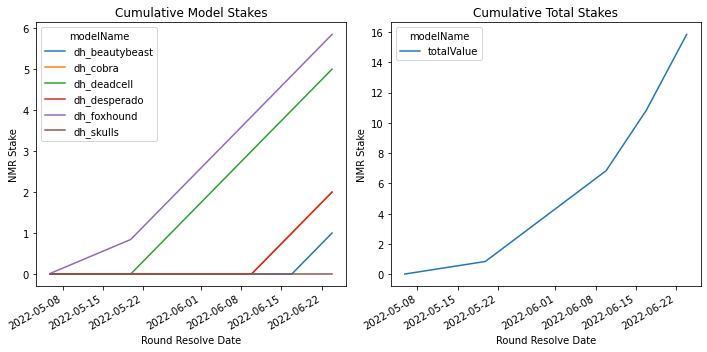

In [13]:
# plot payouts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
staking.loc[AFTER_DATE:][[col for col in staking.columns if col.startswith("dh_")]].cumsum().plot(ax=axes[0])
staking.loc[AFTER_DATE:][["totalValue"]].cumsum().plot(ax=axes[1])
axes[0].set_title("Cumulative Model Stakes")
axes[0].set_xlabel("Round Resolve Date")
axes[0].set_ylabel("NMR Stake")
axes[1].set_title("Cumulative Total Stakes")
axes[1].set_xlabel("Round Resolve Date")
axes[1].set_ylabel("NMR Stake")
plt.tight_layout()
plt.savefig('plots/ModelStakingPlots.png', facecolor='w')
plt.show()

---
# Get total return

In [14]:
# get return
total_return = pd.concat([payout.sum(), staking.tail(1).T], axis=1)
total_return.columns = ["payout", "staking"]
total_return["return"] = total_return["payout"] / total_return["staking"]

total_return

,payout,staking,return
modelName,,,
dh_beautybeast,-0.000333,1.000000,-0.000333
dh_cobra,-0.044579,1.000000,-0.044579
dh_deadcell,0.005958,1.000000,0.005958
dh_desperado,-0.022209,1.000000,-0.022209
dh_foxhound,0.130246,1.002704,0.129895
dh_skulls,0.000000,0.000000,NaN
totalValue,0.069083,5.002704,0.013809


In [15]:
# daily staking 
round_return = pd.concat([payout["totalValue"], staking["totalValue"]], axis=1)[AFTER_DATE:].fillna(0)
round_return.columns = ["payout", "staking"]
round_return["return"] = round_return["payout"] / round_return["staking"]

round_return

,payout,staking,return
roundResolveTime,,,
2022-05-05 20:00:00+00:00,0.000000,0.014453,0.000000
2022-05-12 20:00:00+00:00,0.002033,0.414453,0.004906
2022-05-19 20:00:00+00:00,0.000667,0.414453,0.001609
2022-05-26 20:00:00+00:00,0.035571,2.000003,0.017785
2022-06-02 20:00:00+00:00,0.068884,2.000003,0.034442
2022-06-09 20:00:00+00:00,0.006714,2.000003,0.003357
2022-06-16 20:00:00+00:00,-0.089689,4.002037,-0.022411
2022-06-23 20:00:00+00:00,0.040450,5.002704,0.008086


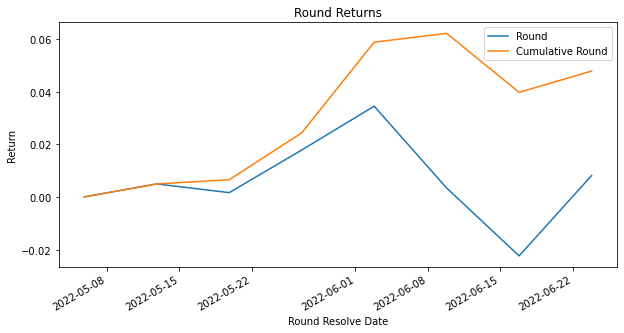

In [16]:
# plot round return
plt.figure(figsize=(10, 5))
round_return["return"].plot()
round_return["return"].cumsum().plot()
plt.legend(["Round", "Cumulative Round"])
plt.title("Round Returns")
plt.xlabel("Round Resolve Date")
plt.ylabel("Return")
plt.savefig('plots/TotalReturnPlots.png', facecolor='w')
plt.show()